In [1]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [2]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [3]:
# DB Config
uid = "아파트4-103-106"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time','kw (15min)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['Date Time'] = [ts['time'] for ts in timeslot]

date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas.index = date_time
hh_datas

,kw (15min)
Date Time,
2018-05-01 00:00:00,0.099
2018-05-01 00:15:00,0.103
2018-05-01 00:30:00,0.084
2018-05-01 00:45:00,0.079
2018-05-01 01:00:00,0.105
...,...
2019-04-30 22:45:00,0.030
2019-04-30 23:00:00,0.033
2019-04-30 23:15:00,0.038


In [4]:
# Split Data Code
split_datas = round(hh_datas[0::4], 3)

# Merging Data Code
count = 0
merge_datas = pd.DataFrame(columns=['kw (15min)'])
merge_datas['kw (15min)'] = [
    round(hh_datas[
        idx * 4:
        (idx + 1) * 4
    ].mean().values[0], 3)
    for idx in range(0, round(len(hh_datas) / 4))
]
merge_datas.index = [
    hh_datas.index[idx * 4]
    for idx in range(0, round(len(hh_datas) / 4))
]

In [5]:
# training datas 80%
# validation datas 10%
# validation datas 10%
val_days = []
test_days = []

val_data_percentage = 10
test_data_percentage = 10

# Mon.1 ~ Mon.12
for month in range(1,13):
    val_day_list = []
    test_day_list = []
    day_list = list(set(
        split_datas[split_datas.index.month == month].index.day
    ))
    month_datas = split_datas[split_datas.index.month == month].copy()
    start_day = day_list[0]
    end_day = day_list[len(day_list) - 1] + 1
    
    # 10 percentage split
    val_length = round(len(day_list)) / val_data_percentage
    test_length = round(len(day_list)) / test_data_percentage
    
    while True:
        if (len(val_day_list) >= val_length) and \
            (len (test_day_list) >= test_length):
            break
        while True:
            val_day = ran.randrange(start_day, end_day)
            test_day = ran.randrange(start_day, end_day)

            if (val_day != test_day) and \
                (val_day not in val_day_list + test_day_list) and \
                (test_day not in test_day_list + val_day_list):
                val_days.extend(
                    month_datas[
                        month_datas.index.day == val_day
                    ].index
                )
                test_days.extend(
                    month_datas[
                        month_datas.index.day == test_day
                    ].index
                )
                val_day_list.append(val_day)
                test_day_list.append(test_day)
                break;

train_days = split_datas.drop((val_days + test_days)).index

In [6]:
# Set Split Datas
train_split_df = split_datas.loc[train_days].copy()
val_split_df = split_datas.loc[val_days].copy()
test_split_df = split_datas.loc[test_days].copy()

# Set Merge Datas
train_merge_df = merge_datas.loc[train_days].copy()
val_merge_df = merge_datas.loc[val_days].copy()
test_merge_df = merge_datas.loc[test_days].copy()

In [7]:
def get_season(month):
    if month in [3,4,5]:
        return "봄"
    elif month in [6,7,8]:
        return "여름"
    elif month in [9,10,11]:
        return "가을"
    else:
        return "겨울"
    
train_mean = train_split_df.mean()
train_std = train_split_df.std()
print("split data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_split = dict({
    "all": (split_datas - train_mean) / train_std,
    "train": (train_split_df - train_mean) / train_std,
    "val": (val_split_df - train_mean) / train_std,
    "test": (test_split_df - train_mean) / train_std,
})
norm_split['season_bak'] = dict({
    'train': pd.DataFrame(),
    'val': pd.DataFrame(),
    'test': pd.DataFrame()
})
norm_split['season_bak']['train']['season'] = [get_season(month) for month in norm_split['train'].index.month]
norm_split['season_bak']['train'].index = norm_split['train'].index

norm_split['season_bak']['val']['season'] = [get_season(month) for month in norm_split['val'].index.month]
norm_split['season_bak']['val'].index = norm_split['val'].index

norm_split['season_bak']['test']['season'] = [get_season(month) for month in norm_split['test'].index.month]
norm_split['season_bak']['test'].index = norm_split['test'].index

train_mean = train_merge_df.mean()
train_std = train_merge_df.std()
print("merge data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_merge = dict({
    "all": (merge_datas - train_mean) / train_std,
    "train": (train_merge_df - train_mean) / train_std,
    "val": (val_merge_df - train_mean) / train_std,
    "test": (test_merge_df - train_mean) / train_std
})


split data // mean: [0.09730809], std: [0.09959084]
merge data // mean: [0.09717593], std: [0.08321385]


In [8]:
windows = dict()
seasons = ['봄', '여름', '가을', '겨울']

for season in seasons:
    season_windows = dict()
    season_idx = dict({
        'train': norm_split['season_bak']['train'][norm_split['season_bak']['train']['season'] == season].index,
        'val': norm_split['season_bak']['val'][norm_split['season_bak']['val']['season'] == season].index,
        'test': norm_split['season_bak']['test'][norm_split['season_bak']['test']['season'] == season].index,
    })
    for WINDOW_WIDTH in range(3, 21):
        season_windows['{} hours'.format(WINDOW_WIDTH)] = WindowGenerator(
            input_width=WINDOW_WIDTH,
            label_width=1,
            shift=1,
            label_columns=['kw (15min)'],
            train_df=norm_split['train'].loc[season_idx['train']],
            val_df=norm_split['val'].loc[season_idx['val']],
            test_df=norm_split['test'].loc[season_idx['test']]
        )
    windows[season] = season_windows

windows

{'봄': {'3 hours': Total window size: 4
  Input indices: [0 1 2]
  Label indices: [3]
  Label column name(s): ['kw (15min)'],
  '4 hours': Total window size: 5
  Input indices: [0 1 2 3]
  Label indices: [4]
  Label column name(s): ['kw (15min)'],
  '5 hours': Total window size: 6
  Input indices: [0 1 2 3 4]
  Label indices: [5]
  Label column name(s): ['kw (15min)'],
  '6 hours': Total window size: 7
  Input indices: [0 1 2 3 4 5]
  Label indices: [6]
  Label column name(s): ['kw (15min)'],
  '7 hours': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['kw (15min)'],
  '8 hours': Total window size: 9
  Input indices: [0 1 2 3 4 5 6 7]
  Label indices: [8]
  Label column name(s): ['kw (15min)'],
  '9 hours': Total window size: 10
  Input indices: [0 1 2 3 4 5 6 7 8]
  Label indices: [9]
  Label column name(s): ['kw (15min)'],
  '10 hours': Total window size: 11
  Input indices: [0 1 2 3 4 5 6 7 8 9]
  Label indices: [10]
  Label column 

In [9]:
val_performance = dict()
performance = dict()
models = dict()

for season in seasons:
    season_val_performance = dict()
    season_performance = dict()
    season_models = dict()
    IPython.display.clear_output()
    print("##### {} training start #####".format(season))
    for WINDOW_WIDTH in range(3, 21):
        key = "{} hours".format(WINDOW_WIDTH)
        print("##### {} training start #####".format(key))

        cur_window = windows[season][key]
        lstm_model = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1)
        ])

        compile_and_fit(lstm_model, cur_window)
        season_val_performance[key] = lstm_model.evaluate(
                    cur_window.val
                )
        season_performance[key] = lstm_model.evaluate(
                    cur_window.test
                )
        season_models[key] = lstm_model
    val_performance[season] = season_val_performance
    performance[season] = season_performance
    models[season] = season_models

##### 겨울 training start #####
##### 3 hours training start #####
Epoch 1/40
51/51 [==============================] - 2s 8ms/step - loss: 1.0698 - mean_absolute_error: 0.6128 - val_loss: 1.0837 - val_mean_absolute_error: 0.6194
Epoch 2/40
51/51 [==============================] - 0s 3ms/step - loss: 1.0321 - mean_absolute_error: 0.6062 - val_loss: 1.0648 - val_mean_absolute_error: 0.6144
Epoch 3/40
51/51 [==============================] - 0s 3ms/step - loss: 1.0194 - mean_absolute_error: 0.5956 - val_loss: 1.0557 - val_mean_absolute_error: 0.6093
Epoch 4/40
51/51 [==============================] - 0s 3ms/step - loss: 1.0120 - mean_absolute_error: 0.5924 - val_loss: 1.0522 - val_mean_absolute_error: 0.6062
Epoch 5/40
51/51 [==============================] - 0s 3ms/step - loss: 1.0045 - mean_absolute_error: 0.5883 - val_loss: 1.0540 - val_mean_absolute_error: 0.5999
Epoch 6/40
9/9 [==============================] - 0s 1ms/step - loss: 1.0460 - mean_absolute_error: 0.6133
##### 4 hours trai

51/51 [==============================] - 0s 4ms/step - loss: 1.0193 - mean_absolute_error: 0.6068 - val_loss: 1.0998 - val_mean_absolute_error: 0.6421
Epoch 12/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0192 - mean_absolute_error: 0.6036 - val_loss: 1.0975 - val_mean_absolute_error: 0.6415
Epoch 13/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0175 - mean_absolute_error: 0.6046 - val_loss: 1.0965 - val_mean_absolute_error: 0.6472
Epoch 14/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0162 - mean_absolute_error: 0.6056 - val_loss: 1.0928 - val_mean_absolute_error: 0.6400
Epoch 15/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0161 - mean_absolute_error: 0.6071 - val_loss: 1.0910 - val_mean_absolute_error: 0.6280
Epoch 16/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0143 - mean_absolute_error: 0.6049 - val_loss: 1.0879 - val_mean_absolute_error: 0.6263
Epoch 17/40
51/51 [===============

Epoch 24/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0071 - mean_absolute_error: 0.6034 - val_loss: 1.0707 - val_mean_absolute_error: 0.6238
Epoch 25/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0086 - mean_absolute_error: 0.6034 - val_loss: 1.0649 - val_mean_absolute_error: 0.6311
Epoch 26/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0068 - mean_absolute_error: 0.6056 - val_loss: 1.0731 - val_mean_absolute_error: 0.6190
Epoch 27/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0031 - mean_absolute_error: 0.6016 - val_loss: 1.0646 - val_mean_absolute_error: 0.6230
Epoch 28/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0012 - mean_absolute_error: 0.6010 - val_loss: 1.0667 - val_mean_absolute_error: 0.6145
Epoch 29/40
51/51 [==============================] - 0s 4ms/step - loss: 0.9994 - mean_absolute_error: 0.5986 - val_loss: 1.0623 - val_mean_absolute_error: 0.6193
Epoch 30/40
51/51 [===

51/51 [==============================] - 0s 4ms/step - loss: 0.9965 - mean_absolute_error: 0.6100 - val_loss: 1.1186 - val_mean_absolute_error: 0.6510
Epoch 16/40
51/51 [==============================] - 0s 4ms/step - loss: 0.9945 - mean_absolute_error: 0.6035 - val_loss: 1.1160 - val_mean_absolute_error: 0.6601
Epoch 17/40
51/51 [==============================] - 0s 4ms/step - loss: 0.9935 - mean_absolute_error: 0.6053 - val_loss: 1.1163 - val_mean_absolute_error: 0.6429
Epoch 18/40
51/51 [==============================] - 0s 4ms/step - loss: 0.9940 - mean_absolute_error: 0.6062 - val_loss: 1.1102 - val_mean_absolute_error: 0.6436
Epoch 19/40
51/51 [==============================] - 0s 4ms/step - loss: 0.9887 - mean_absolute_error: 0.5978 - val_loss: 1.1063 - val_mean_absolute_error: 0.6440
Epoch 20/40
51/51 [==============================] - 0s 4ms/step - loss: 0.9849 - mean_absolute_error: 0.6030 - val_loss: 1.1044 - val_mean_absolute_error: 0.6352
Epoch 21/40
51/51 [===============

8/8 [==============================] - 0s 2ms/step - loss: 1.0534 - mean_absolute_error: 0.6627
##### 16 hours training start #####
Epoch 1/40
51/51 [==============================] - 3s 11ms/step - loss: 1.0578 - mean_absolute_error: 0.6177 - val_loss: 1.2354 - val_mean_absolute_error: 0.6828
Epoch 2/40
51/51 [==============================] - 0s 6ms/step - loss: 1.0247 - mean_absolute_error: 0.6018 - val_loss: 1.2197 - val_mean_absolute_error: 0.6857
Epoch 3/40
51/51 [==============================] - 0s 6ms/step - loss: 1.0186 - mean_absolute_error: 0.6094 - val_loss: 1.2197 - val_mean_absolute_error: 0.6853
Epoch 4/40
51/51 [==============================] - 0s 6ms/step - loss: 1.0148 - mean_absolute_error: 0.6055 - val_loss: 1.2186 - val_mean_absolute_error: 0.6848
Epoch 5/40
51/51 [==============================] - 0s 6ms/step - loss: 1.0122 - mean_absolute_error: 0.6043 - val_loss: 1.2219 - val_mean_absolute_error: 0.6867
Epoch 6/40
8/8 [==============================] - 0s 2ms/

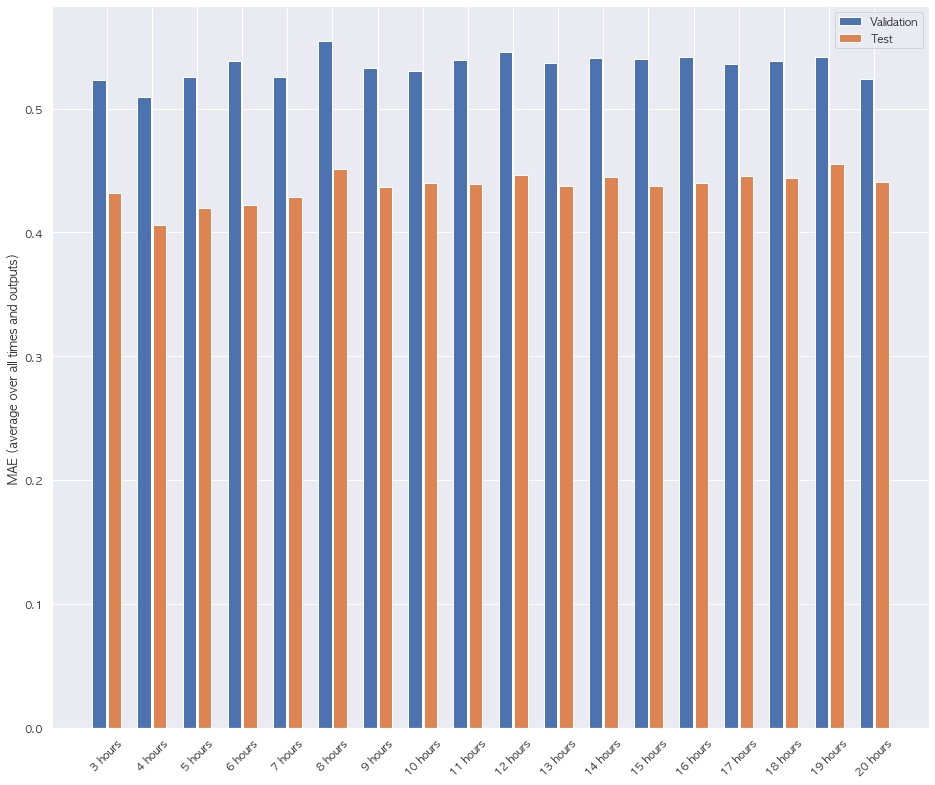

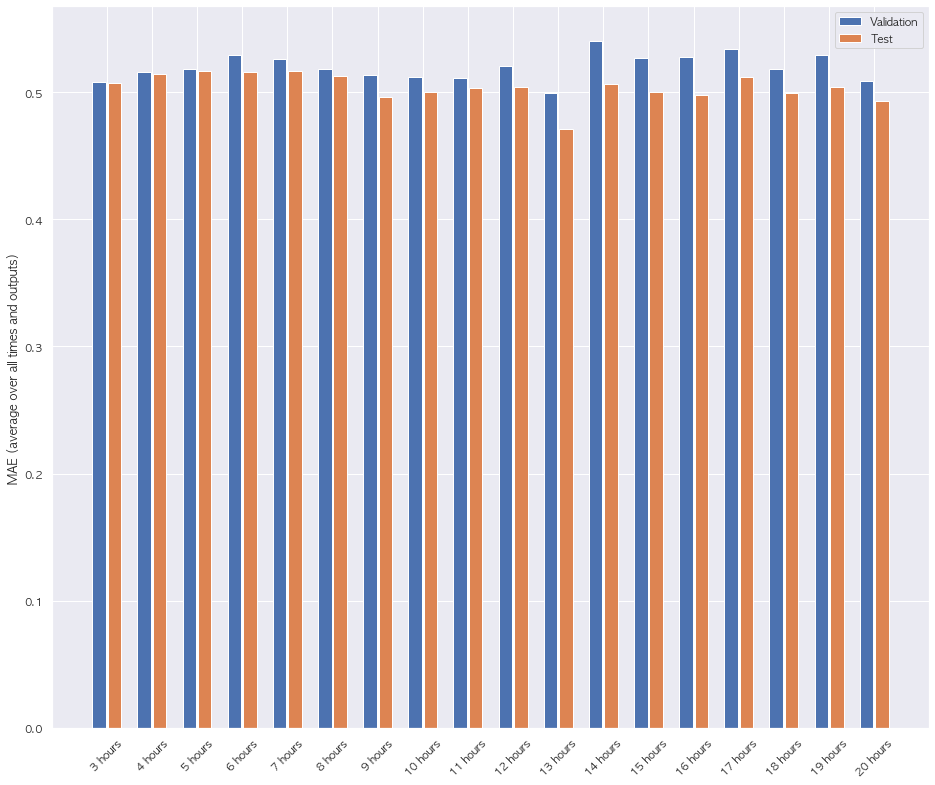

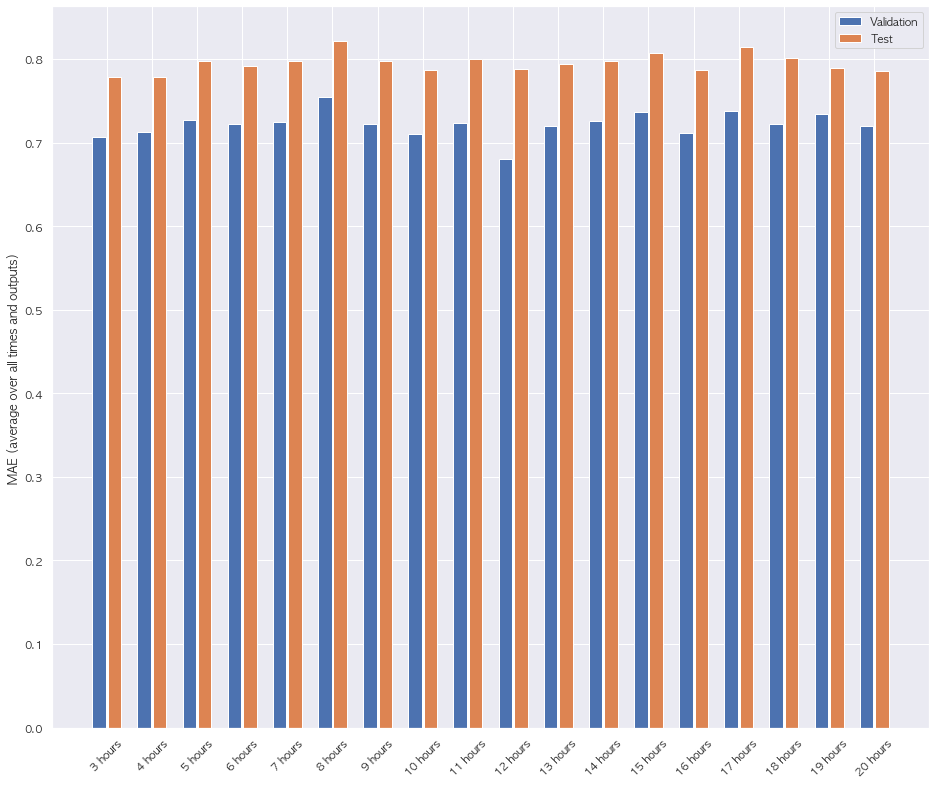

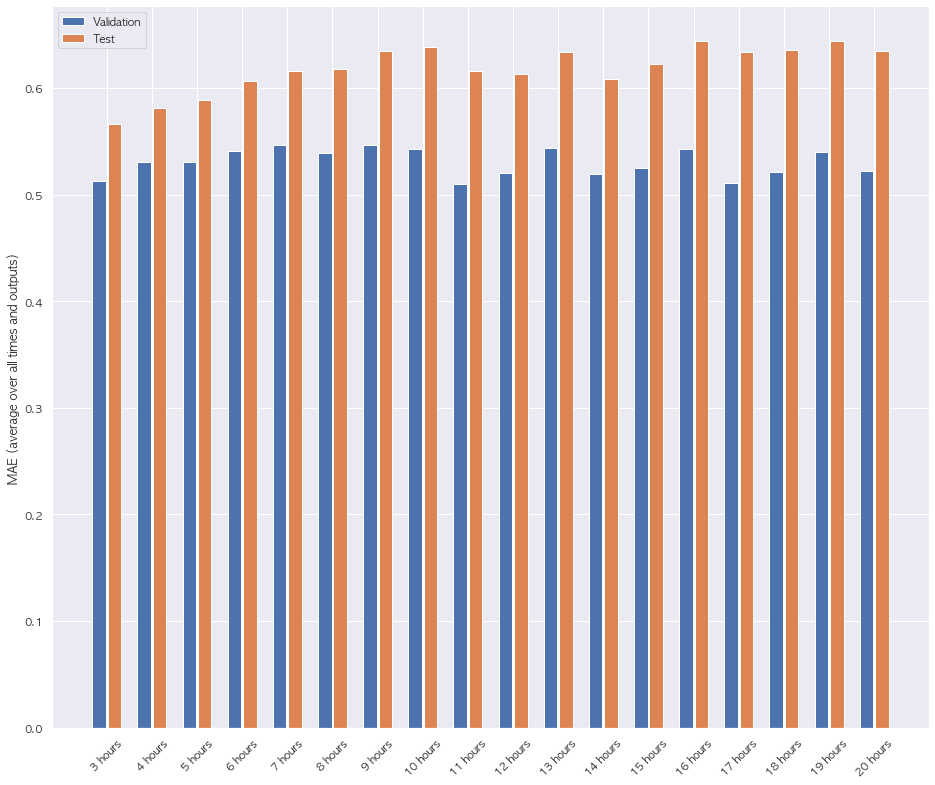

In [15]:
for season in seasons:
    x = np.arange(len(performance[season]))
    width = 0.3

    metric_name = 'mean_absolute_error'
    metric_index = lstm_model.metrics_names.index('mean_absolute_error')
    val_mae = [v[metric_index] for v in val_performance[season].values()]
    test_mae = [v[metric_index] for v in performance[season].values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=performance[season].keys(),
               rotation=45)
    plt.ylabel(f'MAE (average over all times and outputs)')
    _ = plt.legend()
    plt.show()

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

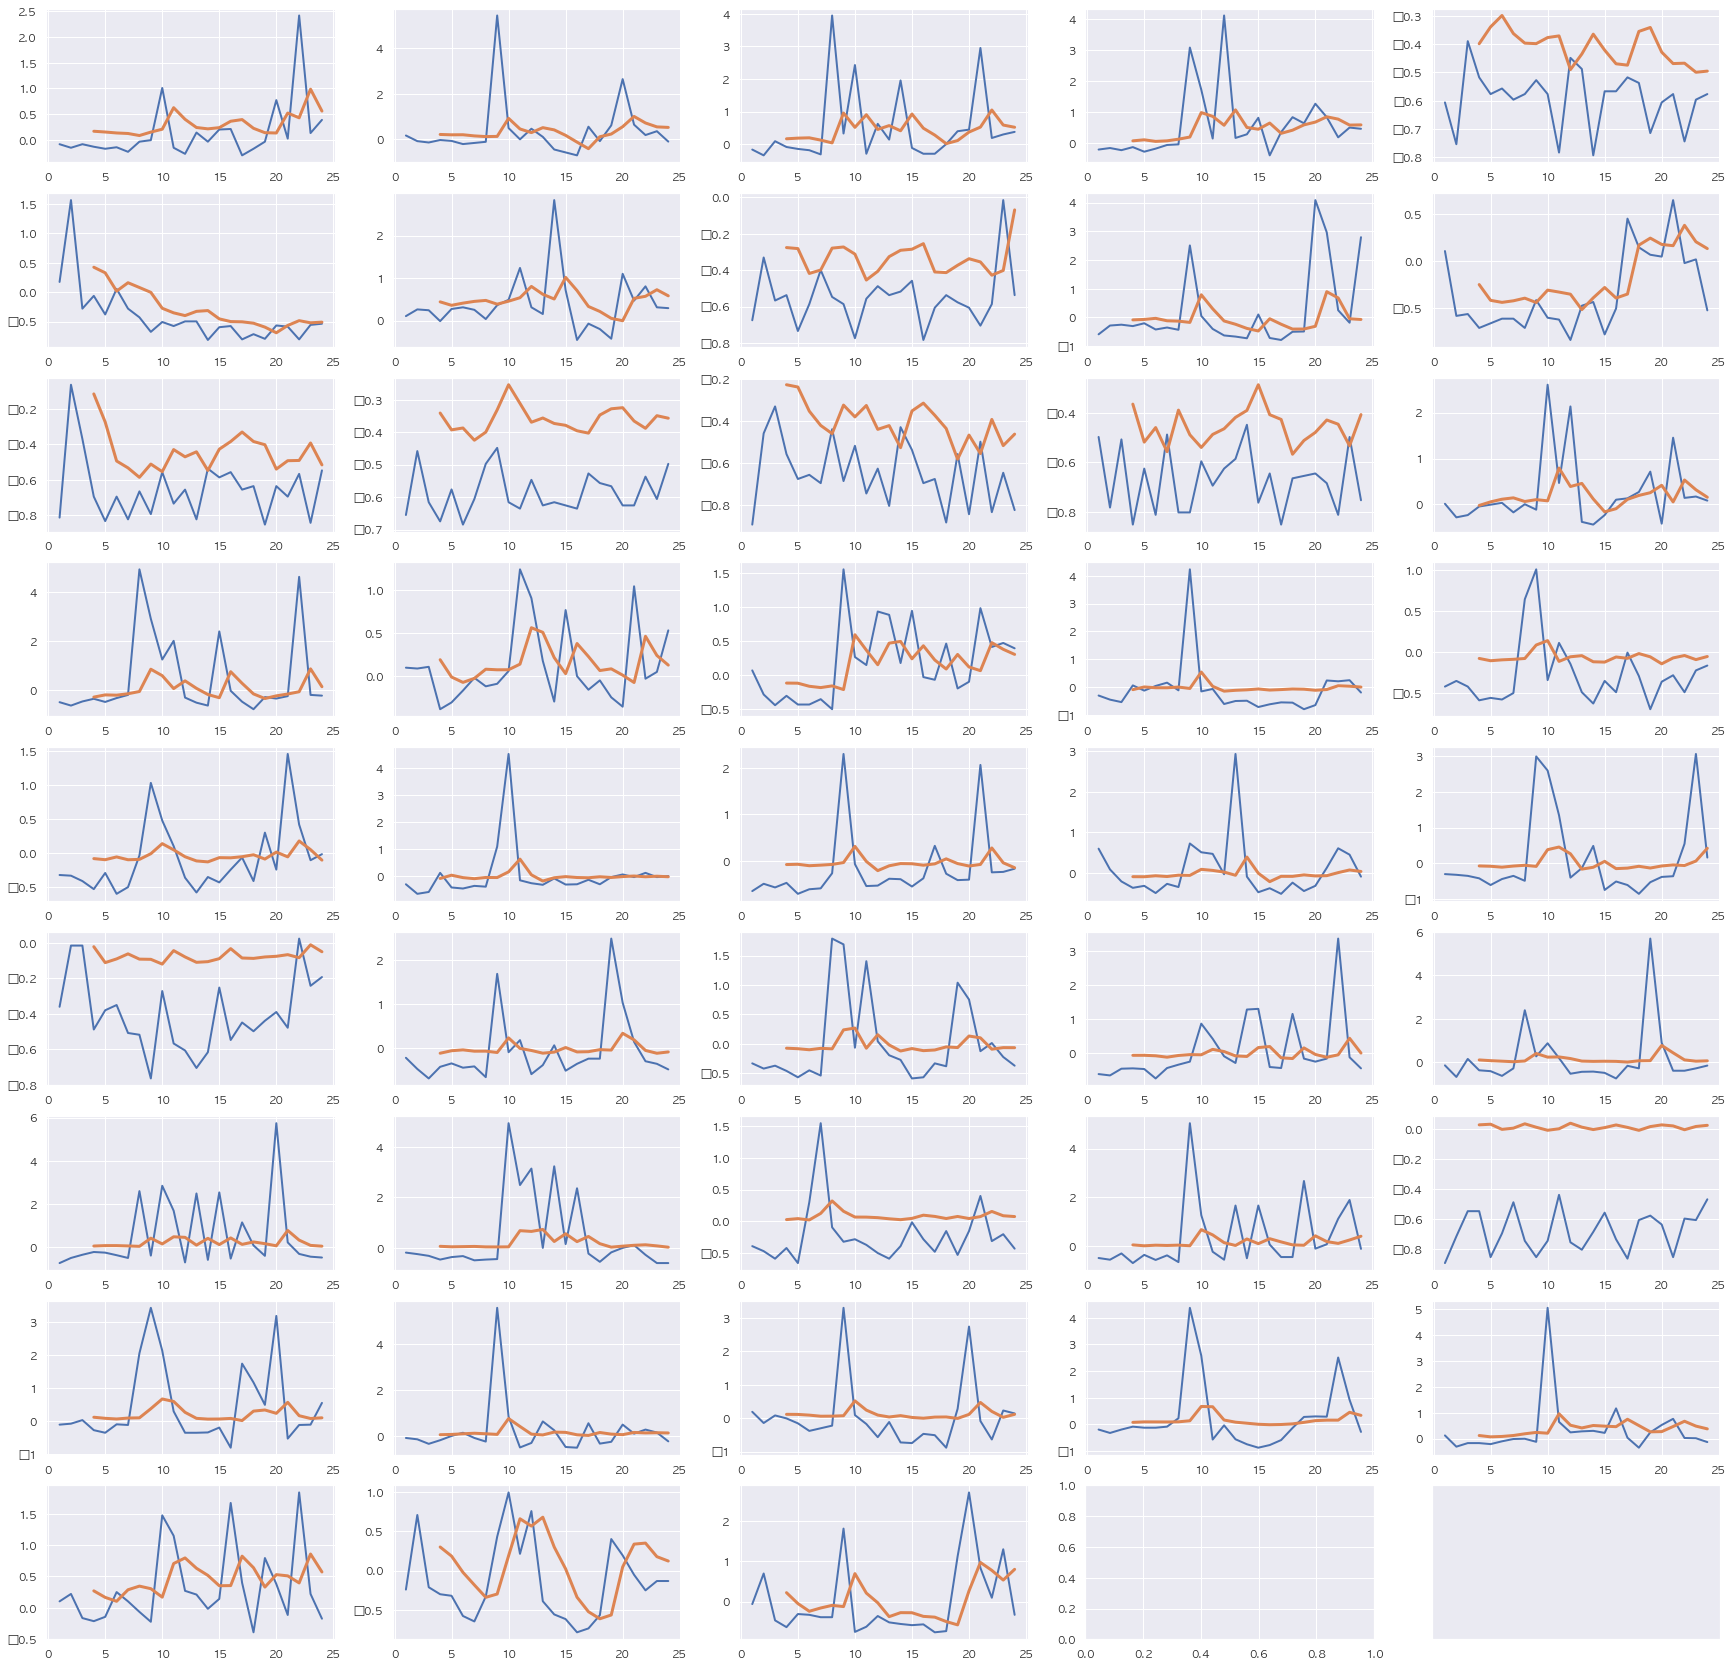

In [21]:
predict_data_length = 3
WINDOW_WIDTH = 3
fig, axes = plt.subplots(math.ceil(round(len(norm_split['test']) / 24) / 5),5, figsize=(30,30))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cnt = 0

for split in range(0, round(len(norm_split['test'])), 24):
    key = "{} hours".format(WINDOW_WIDTH)
    
    date = norm_split['test'][split: (split + 24)].index[0]
    season = get_season(date.month)
    
    original_x_labels = [idx for idx in range(1,25)]
    predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
    original = norm_split['test'][split:(split + 24)].values.flatten()
    predicts = []
    inputs = []
    
    for idx in range(0, (24 - predict_data_length)):
        inputs = norm_split['test'][split:(split + 24)].values.flatten()[idx:predict_data_length + idx]
        inputs = inputs.reshape(-1, predict_data_length,1)
        result = models[season][key](inputs).numpy().flatten()[2]

        predicts.append(result)
        inputs = np.append(inputs.flatten()[1:predict_data_length],result)

    sns.lineplot(original_x_labels, original, lw=2, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
    sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
        
    cnt += 1      

In [22]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

predict_data_length = 3
WINDOW_WIDTH = 3
cnt = 0

evaluater = pd.DataFrame(columns=['mean dis', 'mean sim'])

for WINDOW_WIDTH in range(3, 21):
    print("WINDOW_WIDTH: {}".format(WINDOW_WIDTH))
    distances = np.array([])
    similarities = np.array([])
    for split in range(0, round(len(norm_split['test'])), 24):
        key = "{} hours".format(WINDOW_WIDTH)

        date = norm_split['test'][split: (split + 24)].index[0]
        season = get_season(date.month)
        
        original_x_labels = [idx for idx in range(1,25)]
        predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
        original = norm_split['test'][split:(split + 24)].values.flatten()
        predicts = []
        inputs = []

        for idx in range(0, (24 - predict_data_length)):
            inputs = norm_split['test'][split:(split + 24)].values.flatten()[idx:predict_data_length + idx]
            inputs = inputs.reshape(-1,predict_data_length,1)
            result = models[season][key](inputs).numpy().flatten()[2]

            predicts.append(result)
            inputs = np.append(inputs.flatten()[1:predict_data_length],result)

        distances = np.append(distances, euc(original[predict_data_length:], predicts))
        similarities = np.append(similarities, cos_sim(original[predict_data_length:], predicts))
        cnt += 1
    evaluater.loc[key] = [distances.mean(), similarities.mean()]
        
evaluater

WINDOW_WIDTH: 3
WINDOW_WIDTH: 4
WINDOW_WIDTH: 5
WINDOW_WIDTH: 6
WINDOW_WIDTH: 7
WINDOW_WIDTH: 8
WINDOW_WIDTH: 9
WINDOW_WIDTH: 10
WINDOW_WIDTH: 11
WINDOW_WIDTH: 12
WINDOW_WIDTH: 13
WINDOW_WIDTH: 14
WINDOW_WIDTH: 15
WINDOW_WIDTH: 16
WINDOW_WIDTH: 17
WINDOW_WIDTH: 18
WINDOW_WIDTH: 19
WINDOW_WIDTH: 20


,mean dis,mean sim
3 hours,3.883050,0.368443
4 hours,3.846183,0.355922
5 hours,3.886373,0.351379
6 hours,3.905378,0.278369
7 hours,3.956309,0.279026
8 hours,3.955099,0.292015
9 hours,3.956737,0.291864
10 hours,3.929202,0.319000
11 hours,3.925588,0.309882
12 hours,3.912098,0.353463


In [23]:
evaluater.sort_values(['mean dis', 'mean sim'], ascending=[True, False])

,mean dis,mean sim
4 hours,3.846183,0.355922
3 hours,3.883050,0.368443
5 hours,3.886373,0.351379
6 hours,3.905378,0.278369
12 hours,3.912098,0.353463
11 hours,3.925588,0.309882
10 hours,3.929202,0.319000
13 hours,3.939724,0.302861
14 hours,3.940592,0.305331
15 hours,3.947620,0.303839
